In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import pickle

Using TensorFlow backend.


# Logistic Regression 

In [4]:
#importing data 
users = pd.read_csv('users.csv', index_col=0)
scammers = pd.read_csv('scammers.csv', index_col=0)

In [7]:
# overwriting usernames with targets
# 0 for users 
# 1 for scammers
users['username'] = 0
scammers['username'] = 1

In [10]:
#dropped employee column because there are no reddit employees in the data set
users.drop('employee', axis=1, inplace=True)

### Column definitions 
- Email column indicates if the user varified their email 
- mod column indicates if the user is a moderator of any subreddit 
- gold column indicates if they have reddit gold 
- Karma column is the amount of karma 
- age column indicates the age of the account 
- comment len indicates if they have at least 100 comments and if not how many.  

In [15]:
users.head()

,username,email,mod,gold,karma,age,comment_len
0,0,True,True,False,54531,1555,100.0
1,0,True,False,False,3784,1325,100.0
2,0,True,True,False,13055,3506,100.0
3,0,True,False,False,246,805,100.0
4,0,True,False,False,23845,1325,100.0


In [16]:
scammers.head()

,username,email,mod,gold,karma,age,comments
0,1,True,True,False,1082,1452,100
1,1,False,False,False,417,331,100
2,1,False,False,False,177,9,13
3,1,True,False,False,48,167,100
4,1,True,False,False,119,192,44


In [17]:
users.columns = ['username', 'email', 'mod', 'gold', 'karma', 'age', 'comments']

In [18]:
#merging both data frames 
df = pd.concat([users, scammers])

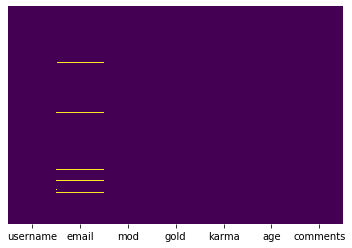

In [19]:
#Checking for null data 
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [20]:
df.isnull().sum()

username      0
email       231
mod           0
gold          0
karma         0
age           0
comments      5
dtype: int64

In [21]:
# will drop the rows with null values 
df.dropna(inplace=True)

## EDA

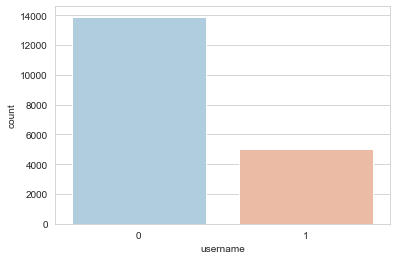

In [22]:
# Amount of Users vs Scammers in data set 
sns.set_style('whitegrid')
sns.countplot(x='username',data=df,palette='RdBu_r')

### Age 

In [23]:
df['age_bins'] = pd.cut(x=df['age'], bins=[0, 90, 180, 360, 540, 720, 900, 1080, 1240, 1420, 10000])

[Text(0, 0, '(0, 90]'),
 Text(0, 0, '(90, 180]'),
 Text(0, 0, '(180, 360]'),
 Text(0, 0, '(360, 540]'),
 Text(0, 0, '(540, 720]'),
 Text(0, 0, '(720, 900]'),
 Text(0, 0, '(900, 1080]'),
 Text(0, 0, '(1080, 1240]'),
 Text(0, 0, '(1240, 1420]'),
 Text(0, 0, '(1420, 10000]')]

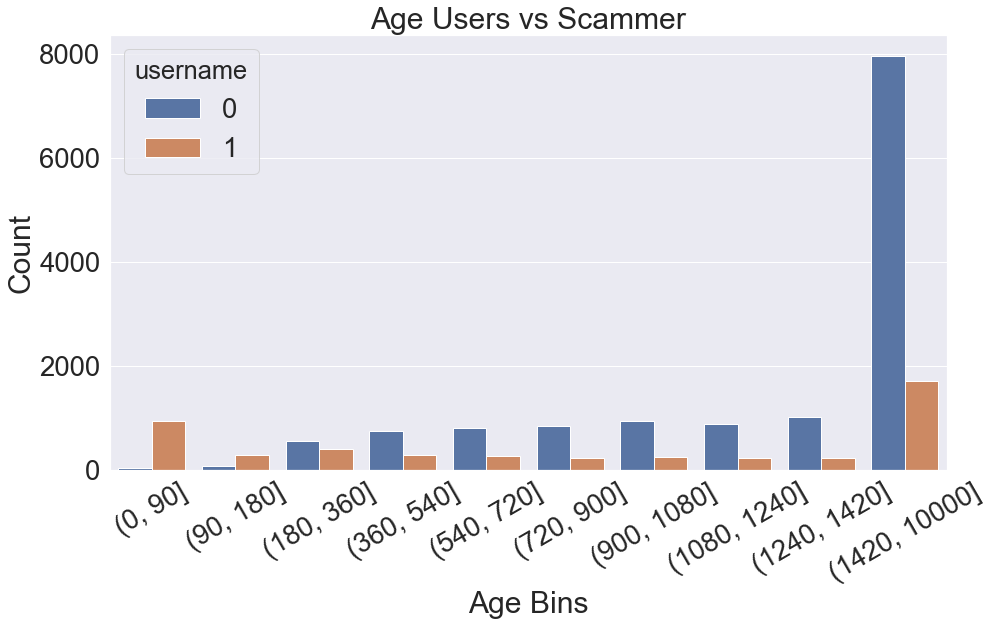

In [33]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(df['age_bins'], hue=df['username'])
sns.set(font_scale=2.5)
ax.set(xlabel='Age Bins', ylabel='Count', title='Age Users vs Scammer')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

#### Higher distribution of scammers in younger accounts 

### Karma

In [27]:
df['karma_bins'] = pd.cut(x=df['karma'], bins=[0, 30, 100, 250, 500, 1000, 2500, 5000, 10000, 25000, 10000000])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

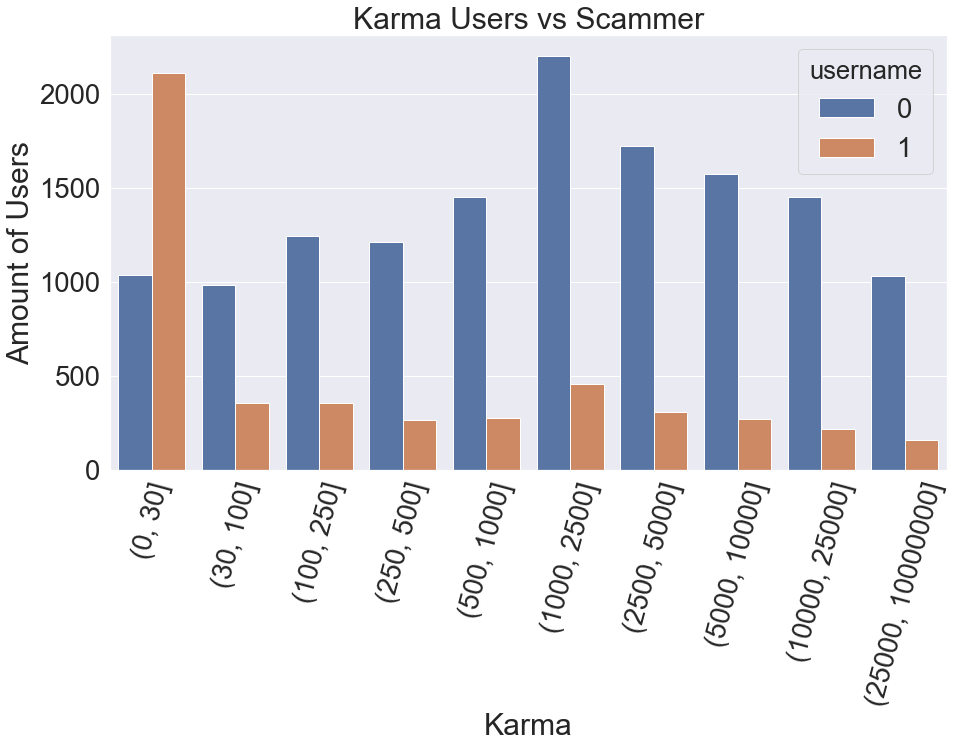

In [31]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(df['karma_bins'], hue=df['username'])
sns.set(font_scale=2.5)
ax.set(xlabel='Karma', ylabel='Amount of Users', title='Karma Users vs Scammer')
plt.xticks(rotation=75)

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Karma'),
 Text(0.5, 1.0, 'Karma Users vs Scammer')]

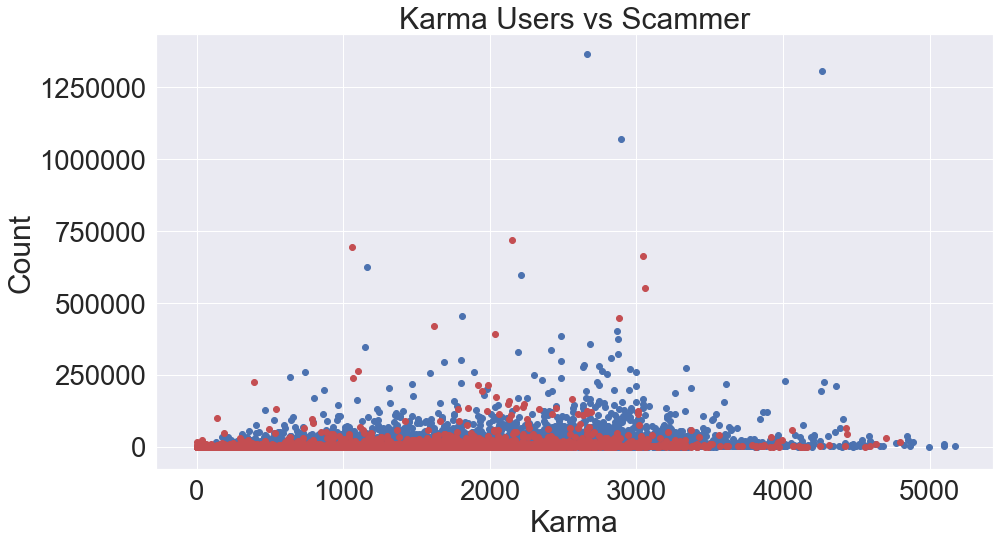

In [32]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.scatter(users['age'], users['karma'], c='b' )
plt.scatter(scammers['age'], scammers['karma'], c='r',  )
sns.set(font_scale=2.5)
ax.set(xlabel='Karma', ylabel='Count', title='Karma Users vs Scammer')

## Email

[Text(0, 0, 'False'), Text(0, 0, 'True')]

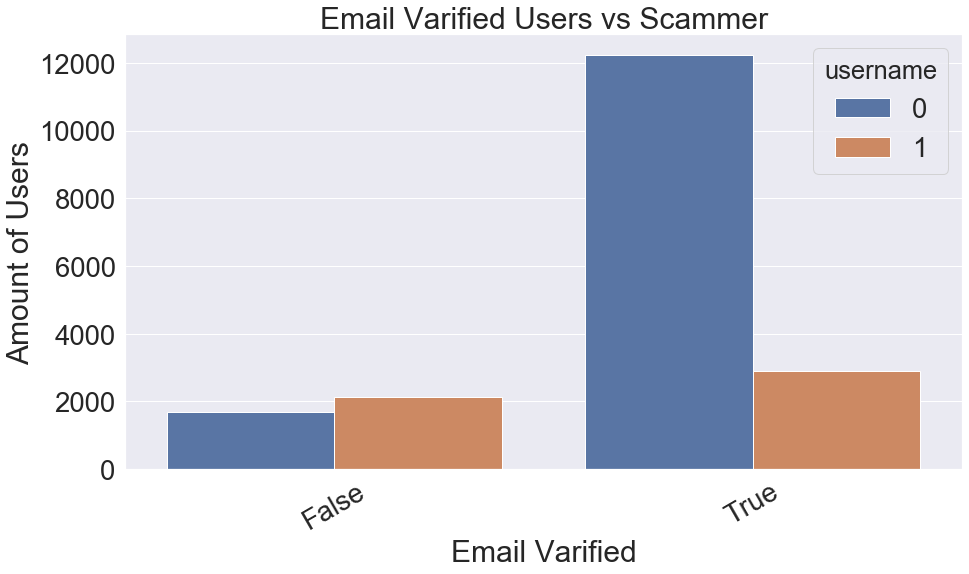

In [35]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(df['email'], hue=df['username'])
sns.set(font_scale=2.5)
ax.set(xlabel='Email Varified', ylabel='Amount of Users', title='Email Varified Users vs Scammer')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

## Gold

[Text(0, 0, 'False'), Text(0, 0, 'True')]

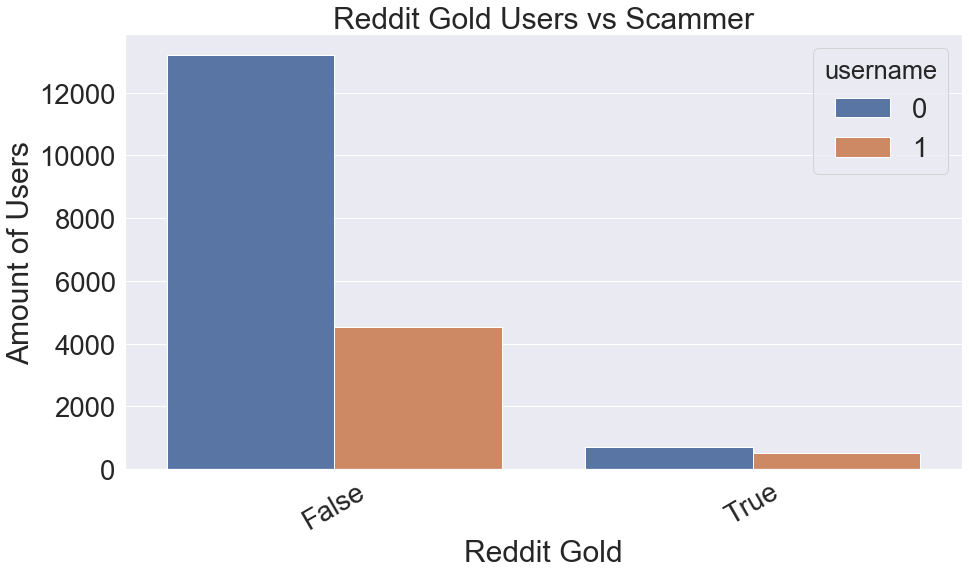

In [36]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(df['gold'], hue=df['username'])
sns.set(font_scale=2.5)
ax.set(xlabel='Reddit Gold', ylabel='Amount of Users', title='Reddit Gold Users vs Scammer')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

## Mod

[Text(0, 0, 'False'), Text(0, 0, 'True')]

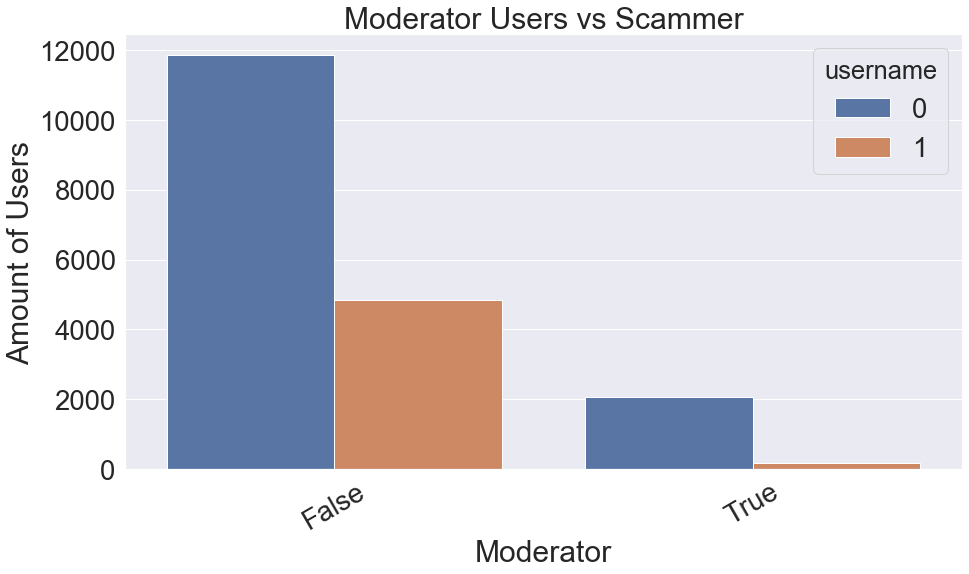

In [37]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(df['mod'], hue=df['username'])
sns.set(font_scale=2.5)
ax.set(xlabel='Moderator', ylabel='Amount of Users', title='Moderator Users vs Scammer')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

## Comments

In [39]:
df['comment_bins'] = pd.cut(x=df['comments'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

[Text(0, 0, '(0, 10]'),
 Text(0, 0, '(10, 20]'),
 Text(0, 0, '(20, 30]'),
 Text(0, 0, '(30, 40]'),
 Text(0, 0, '(40, 50]'),
 Text(0, 0, '(50, 60]'),
 Text(0, 0, '(60, 70]'),
 Text(0, 0, '(70, 80]'),
 Text(0, 0, '(80, 90]'),
 Text(0, 0, '(90, 100]')]

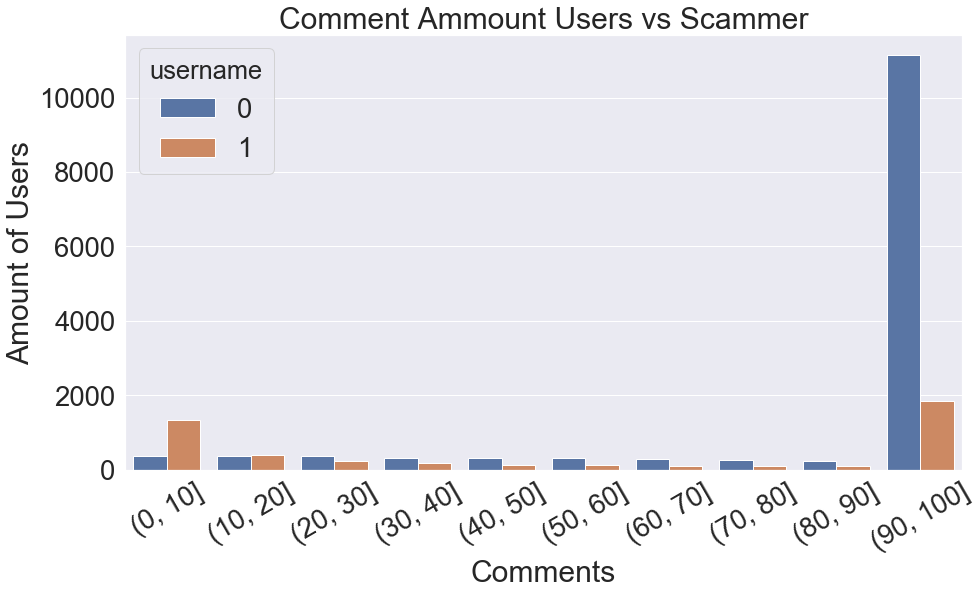

In [41]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(df['comment_bins'], hue=df['username'])
sns.set(font_scale=2.5)
ax.set(xlabel='Comments', ylabel='Amount of Users', title='Comment Ammount Users vs Scammer')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)